### Installing dependencies for preprocessing of images 

In [5]:
!pip install imutils -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [6]:
# !pip install tensorflow --upgrade -q

## Load Libraries

In [41]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D, Dropout, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

## Loading Images

In [8]:
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"

In [9]:
image_dir = '../input/brain_tumor_dataset/'

In [10]:
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

## Augmentation of images 
About the data: The dataset contains 2 folders: 'yes' and 'no' which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and no contains 98 Brain MRI Images that are non-tumorous.**

In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [12]:
!pwd

/kaggle/working


In [13]:
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=4, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=4, save_to_dir=augmented_data_path+'no')

In [14]:
# !ls '../input/brain_tumor_dataset'
# df = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'

## Preprocessing the data

In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

## After applying the cropping function

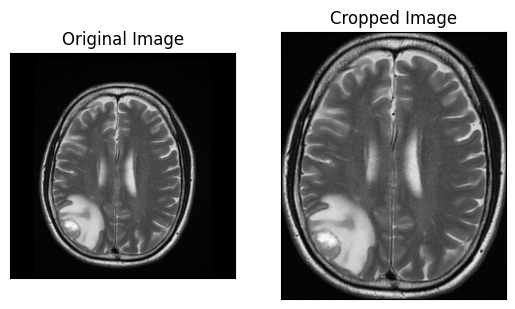

In [16]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [17]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [18]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2063
X shape is: (2063, 240, 240, 3)
y shape is: (2063, 1)


## Visualization of data

In [19]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

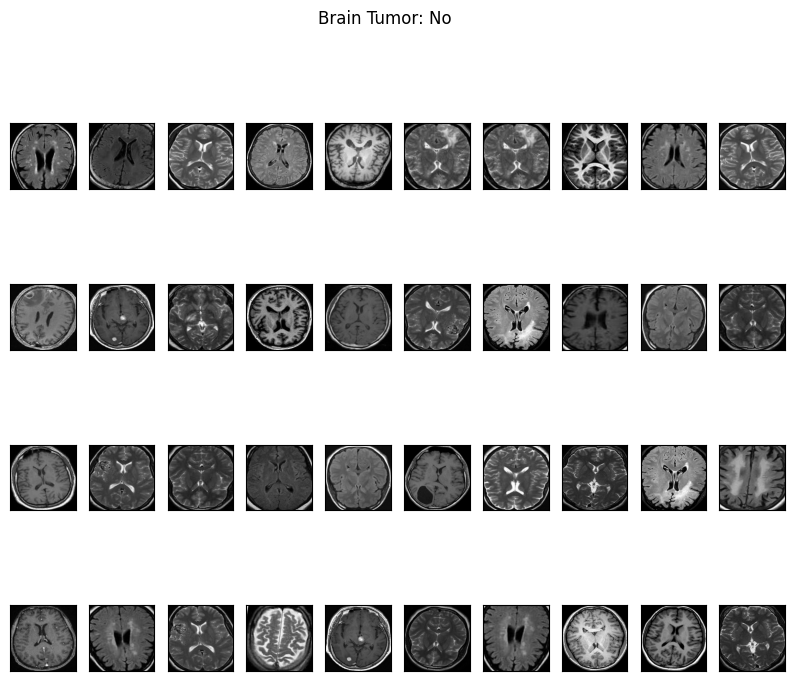

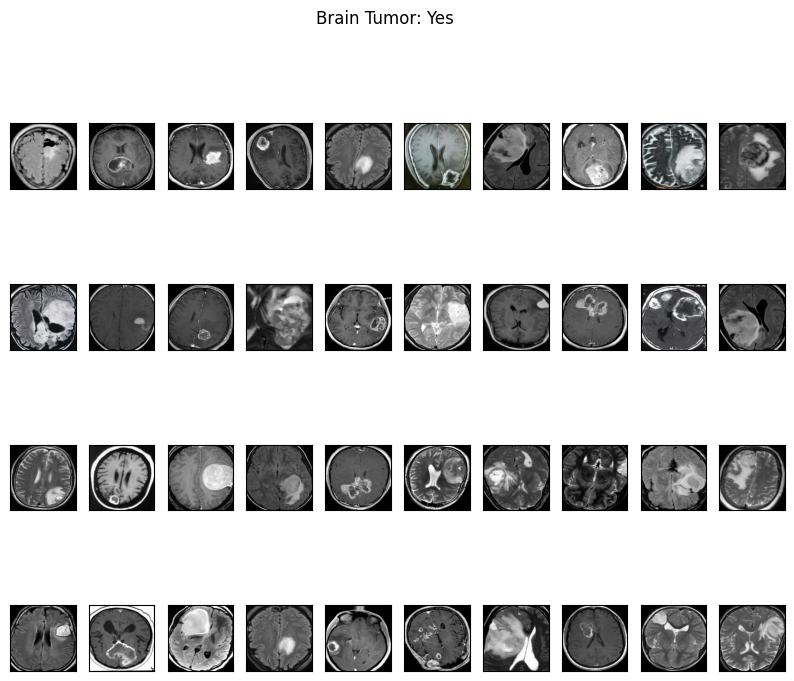

In [20]:
plot_sample_images(X, y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [22]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1547
number of test examples = 516


In [42]:
def build_model(input_shape):
    model = Sequential()
    model.add(Input(input_shape))

    # augmentation
    model.add(RandomRotation(factor=(0,0.5)))
    model.add(RandomFlip(mode="horizontal_and_vertical"))
    model.add(RandomContrast(factor=(0,0.5)))
    
    model.add(Conv2D(16,5,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(32,5,activation="relu"))
    model.add(Conv2D(32,5,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,7,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation="sigmoid"))
    
    return model

In [43]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 240, 240, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 240, 240, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 236, 236, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 114, 114, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 110, 110, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 49, 49, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     3,686,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,826,697 (14.60 MB)

 Trainable params: 3,826,697 (14.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# !pip install --upgrade nvidia-cudnn-cu11 = 9.3.0

In [29]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# # tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, validation_split = 0.3, epochs=25)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.5001 - loss: 1.2952 - val_accuracy: 0.5419 - val_loss: 0.6747
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6395 - loss: 0.6498 - val_accuracy: 0.6774 - val_loss: 0.6313
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6688 - loss: 0.6179 - val_accuracy: 0.6774 - val_loss: 0.6301
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7362 - loss: 0.5877 - val_accuracy: 0.7097 - val_loss: 0.6008
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7262 - loss: 0.5908 - val_accuracy: 0.7097 - val_loss: 0.6082
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7329 - loss: 0.5673 - val_accuracy: 0.6548 - val_loss: 0.6086
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6745 - loss: 0.6048 - val_accuracy: 0.7323 - val_loss: 0.5700
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7491 - loss: 0.5333 - val_accuracy: 0.7129 - v

In [45]:
history = model.history.history

### Plotting Training

In [46]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    fig = plt.subplots(2,1,figsize=(20,10))
    
    # Loss
    plt.subplot(2,1,1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(2,1,2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

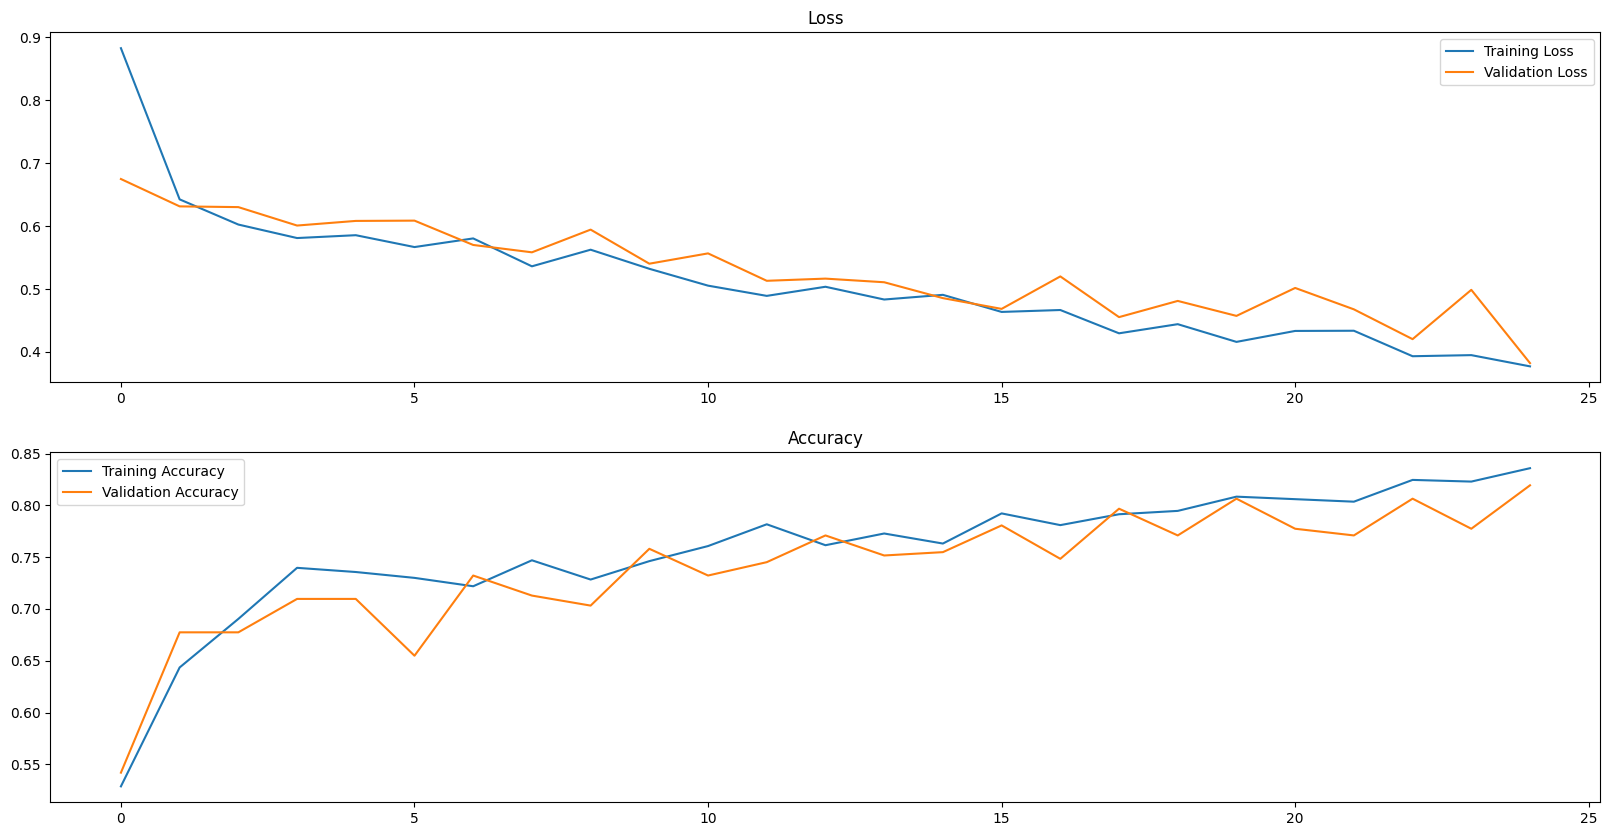

In [47]:
plot_metrics(history)

In [48]:
prediction = model(X_test[:10], training=False)
prediction = np.array(prediction).round()

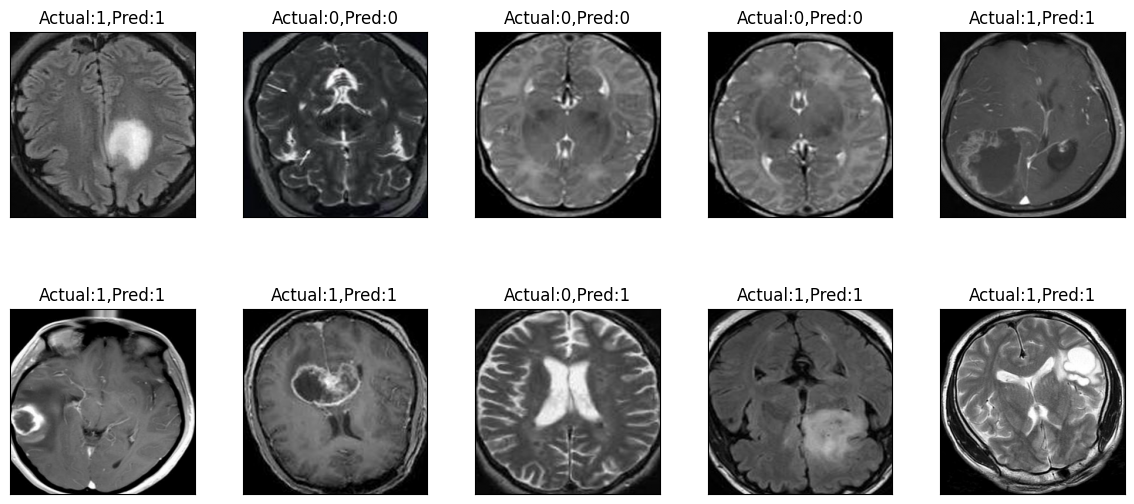

In [49]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):
    axs[i].imshow(X_test[i])
    axs[i].set_title(f"Actual:{y_test[i][0]},Pred:{int(prediction[i][0])}")
    axs[i].tick_params(axis='both', which='both',  top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)